# Tutorial 2: Non-Gaussian Measurements

**API Version: Python NavAbilitySDK.py**

## Applications with Ambiguous Data

There are many, many ways in which non-Gaussian / ambiguous measurements occur, this tutorial will simply pick one common example to illustrate the basic concepts.  In short, measurements do not have to follow a unimodal bell curve (i.e. normal/Gaussian) but can instead introduce non-Gaussian beliefs.

- Localizing ground robots suffering **wheel slip or getting stuck** (rotary encoders),
- Fusing **ambiguous RADAR** data into navigation for driving autonomy,
- Mapping underwater structures from ambiguous **SONAR data**,
- Overcoming gearbox **backlash in kinematic** robot arms / legs,
- Navigating ground / marine surface vehicles through GNSS, radio, laser ranging signal multipath situations (e.g. - **urban canyon**),
- And many more.

### A Basic 1D Example

There are many, many ways in which non-Gaussian / ambiguous measurements occur, this tutorial will simply pick one common example to illustrate the basic concepts.  In short, measurements do not have to follow a unimodal bell curve (i.e. normal/Gaussian) but can instead introduce non-Gaussian beliefs.

We ground the tutorial in an example: imagine a wheeled robot travelling along in a straight line, using wheel encoders to estimate the distance travelled.  There is, however, a quirk, from time to time the robot gets stuck on something and the wheels spin for a few rotations before progress continues.  

![Tutorial 2 Img](https://github.com/NavAbility/BinderNotebooks/raw/main/static/icra-2/example-wheelslip.png)

We assume that our software is able to detect when the wheels are slipping, but by how much is unclear.  We take it that when slip is detected, the distance of slip measurement is only 40% accurate.  In this tutorial, we will build a basic robot localization process that can handle this \"bad\" measurement data.  

To help familiarize yourself with multi-modal beliefs, we limit this tutorial to a one dimensional example with only a few variables and factors.  This tutorial introduces non-Gaussian behavior through non-Gaussian measurements in the factor graph.  At the end of the page, we link to an example that is 2D, real-world, and has non-Gaussian odometry.

This example shows [one of four](https://juliarobotics.org/Caesar.jl/latest/concepts/why_nongaussian/) mechanisms by which non-Gaussian behavior can be introduced into a factor graph solution, see other tutorials for other mechanisms.  The ambiguous measurement example shown in this tutorial can readily be incorporated in other use cases.

The tutorial shows how multi-modal uncertainty can be introduced from non-Gaussian measurements, and how that is transmitted through the system.  We will build a factor graph that contains multi-modal belief as well as `Uniform` and `Rayleigh` distributions.  We can construct factor graph of heterogeneous data and let the joint inference find the best marginal posterior estimates on each of the desired variables in the factor graph.


### Signatures Used

`ContinuousScalar`, `Prior`, `LinearRelative`, `Mixture`, `Normal`

## Ambiguous Data Example

The first step is to load the `NavAbilitySDK` functionality and a few other library features,

In [ ]:
# # ONLY IF REQUIRED, Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install navabilitysdk

In [ ]:
from navability.entities import *
from navability.services import *
from uuid import uuid4
import asyncio

 
## Starting a 1D Factor Graph

### Variable, `ContinuousScalar`

The first thing to do is setup a client-context to talk with the NavAbility Platform.
The next step is to describe the inference problem with a graphical model by populating the factor graph with variable nodes.
The variable nodes are identified by `String`s, namely `x0, x1, x2, x3`.

In [ ]:
navability_client = NavAbilityHttpsClient()
# you need a unique userId:robotId, and can keep using that across all tutorials
userId = "guest@navability.io"
robotId = "SDKpy_"+(str(uuid4())[0:3])

sessionId = "Tutorial2_"+(str(uuid4())[0:3])
client = Client(userId, robotId, sessionId)

In [ ]:
# add the first node
v = Variable("x0", VariableType.ContinuousScalar.value)

result_id = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_id}")

# Wait for it to be loaded.
await waitForCompletion(navability_client, [result_id])

### Prior Factor, (Euclidean(1))

Factor graphs are bipartite graphs with `factors` that act as mathematical structure between interacting `variables`.
After adding node `x0`, a singleton factor of type `Prior` (which was defined by the user earlier) is 'connected to' variable node `x0`.
This unary factor is taken as a `Normal` distribution with zero mean and a standard deviation of `1`.


In [ ]:
# this is unary (prior) factor and does not immediately trigger autoinit of :x0.
prior = Factor("x0f1", "Prior", ["x0"],
      FactorData(
          fnc=Prior(
              Z=Normal(0, 1)
          ).dump()  # This is a generator for a Prior
      ))
# REF: addFactor!(fg, [:x0], Prior(Normal(0,1)))
result_id = await addFactor(navability_client, client, prior)

**Note**, this example is using just `Prior`, which is a simplification for the sake of this tutorial.  Look out for on-manifold prior factors in other code examples.

### Visualizing Graph Topology

Visualization for the SDK interfaces is provided by the NavAbility WebApp, click the generated graphics to open the link:

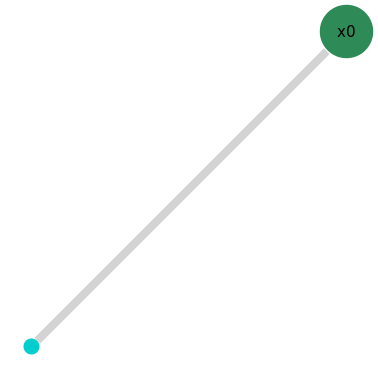

In [3]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
GraphVizApp(client)

The topological graph plot obtained from the NavAbility App above shows the two node factor graph, one variable and one prior factor.  This example uses graph-based automatic variable initialization which was discussed in ICRA 2022 Tutorial 1.

### Next Variable and Relative Factor

Now let's add a second variable `x1`, and connect it to `x0` with a `LinearRelative` factor.

In [ ]:
# add x1
v = Variable("x1", "IncrementalInference.ContinuousScalar") #VariableType.ContinuousScalar.value)
result_id = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_id}")

await getStatusLatest(navability_client, result_id)


# P(Z | :x1 - :x0 ) where Z ~ Normal(10,1)
f = Factor("x0x1f1", "LinearRelative", ["x0", "x1"],
      FactorData(
          fnc=LinearRelative(Normal(10, 0.1)
          ).dump()  # This is a generator for a LinearRelative
      ))
result_id = await addFactor(navability_client, client, f)

### Visualizing the Variable Probability Belief

The NavAbility WebApp allows visualization (plotting) of the belief state over any of the variable nodes.
Remember the first time executions are slow given the required code compilation, and that future versions of these packages will use more precompilation to reduce first execution running cost.

We first need to trigger a solve for the web application to update its belief estimates. We first make sure that the all tasks have completed:


In [ ]:
# let's wait to make sure all nodes were added
await waitForCompletion(navability_client, [result_id])


and then trigger the solve. The current belief estimate is ploted in the NavAbility WebApp as soon as the results become available.

In [ ]:
solve_request = await solveSession(navability_client, client)
print('running solve...')

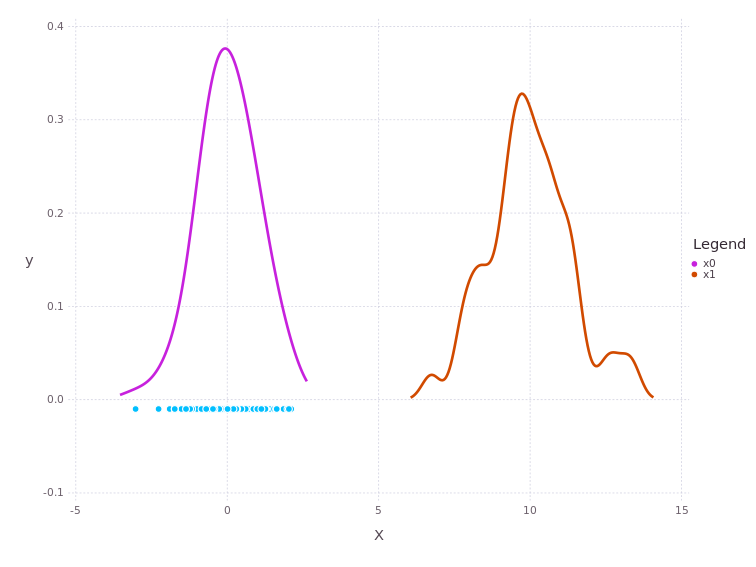

In [6]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
MapVizApp(client)

**TIP**, click the "SHOW DISTRIBUTIONS" button in the NavAbility App geometric visualization page to see the belief estimates of solved variables.  You can also "HIDE PPES" parametric point estimates.

The predicted influence of the `P(Z| X1 - X0) = LinearRelative(Normal(10, 1))` is shown by the `x1` trace.
The predicted belief of `x1` is nothing more than the approximated convolution of the current marginal belief of `x0` with the conditional belief described by `P(Z | X1 - X0)`.

## Non-Gaussian Measurement to `x2`

### Non-parametric Measurements

**Important Side Note**: Thus far, this tutorial has used parametric noise models, but the solver can equally consume nonparametric measurements in factors.  These include kernel density estimates, intensity (heat) maps, and more.  To simplify introduction of non-Gaussian noise models, this tutorial will include the simplest form, namely mixture distributions.  A link to a fully non-parametric marine radar example is provided at the end of this tutorial.

### Mixture Distribution on Next Relative Factor (Wheel Slip)

As the robot continues to drive from `x1` to `x2`, the robot software detects wheel slip has occurred.  Here then is the critical point, how should the next odometry measurement incorporate this ambiguous information.  First, we add the next `ContinuousScalar` variable `x2` as before.  

In [ ]:
v = Variable("x2", "IncrementalInference.ContinuousScalar") #VariableType.ContinuousScalar.value)
result_id = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_id}")

This time, however, the odometry factor from `x1` uses a more complicated `Mixture` likelihood function.  Given a 40% accuracy in wheel slip detection, we are going to construct a `Mixture` distribution as the measurement, where 40% weight goes to what we think the distance travelled is while the remaining 60% weight is designated to 'faulty' odometry measurement.  

Taking the full encoder turns as 60 units distance, with slip being detected on and off throughout, we estimate the majority slip case as a Rayleigh distribution from 0.  Since we know very little about the non-slip case, let's take the robot distance traveled as uniformly distributed somewhere between 40 up to 60 units. 

In [ ]:
mixture_factor = Factor("x1x2f1", "Mixture", ["x1", "x2"],
      FactorData(
            fnc=Mixture(LinearRelative, 
                {
                    "slip": Rayleigh(5), 
                    "noslip": Uniform(35,60)
                },
                [0.4, 0.6],
                2
          ).dump()
      ))
print(mixture_factor.dumps())
result_id = await addFactor(navability_client, client, mixture_factor)

# let's wait to make sure all nodes were added
await waitForCompletion(navability_client, [result_id])


The `mmo` variable illustrates how a near arbitrary mixture probability distribution can be used as a conditional relationship between variable nodes in the factor graph.
In this case, a 40%/60% balance of a Rayleigh and truncated Uniform distribution which acts as a multi-modal conditional belief.
Interpret carefully what a conditional belief of this nature actually means.

Following the tutorial's practical example frameworks (robot navigation or time travel), this multi-modal belief implies that moving from one of the probable locations in `x1` to a location in `x2` by some processes defined by `mmo=P(Z | X2, X1)` is uncertain to the same 40%/60% ratio.
In practical terms, collapsing (through observation of an event) the probabilistic likelihoods of the transition from `x1` to `x2` may result in the `x2` location being at either 15-20, or 40-65-ish units.
The predicted belief over `x2` is illustrated by plotting the predicted belief after triggering a new solve.

In [ ]:
solve_request = await solveSession(navability_client, client)
print('running solve...')

The results visualization updates automatically as the solver finishes. Here is the link to the Geometric map visualizations in th App again:

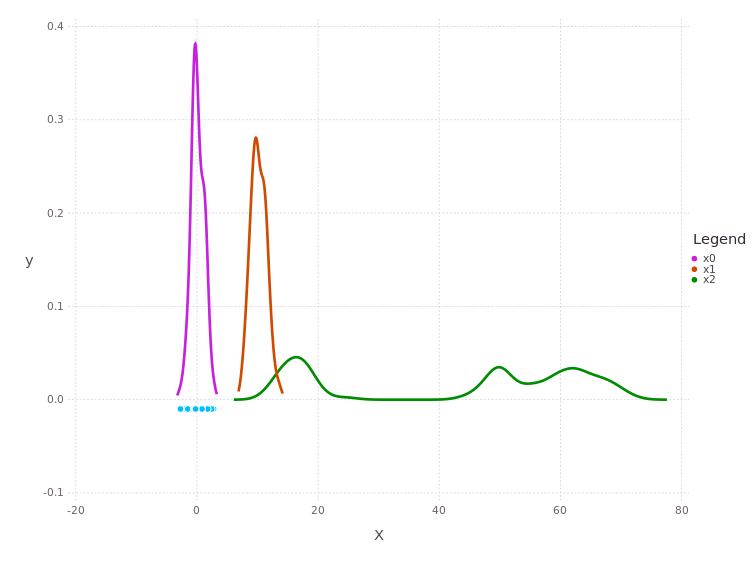

In [7]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
MapVizApp(client)

Notice the multi-modal belief in the marginal posterior belief of `x2`.  Also note that Kernel Density Estimate methods can appear to produce noisy belief density estimates.  While this does sometimes occur, it is harmless and has no impact on the accuracy of the mean point estimate produced for each mode in the associated belief.


## Adding Variable `x3`

In suspecting that the robot did get stuck and had its wheels slip, we reverse the robot 50 units and add pose variable `x3`,  i.e. a factor measurement `LinearRelative(Normal(-50,1))`

In [ ]:
v = Variable("x3", "IncrementalInference.ContinuousScalar") #VariableType.ContinuousScalar.value)
result_id = await addVariable(navability_client, client, v)
print(f"Added {v.label} with result ID {result_id}")

linear_factor = Factor("x2x3f1", "LinearRelative", ["x2", "x3"],
      FactorData(
          fnc=LinearRelative(Normal(-50, 1)
          ).dump()  # This is a generator for a LinearRelative
      ))
result_id = await addFactor(navability_client, client, linear_factor)

# let's wait to make sure all nodes were added
await waitForCompletion(navability_client, [result_id])

expands the factor graph to four variables and four factors.
This part of the tutorial shows how a unimodal likelihood (conditional belief) can transmit the bimodal belief currently contained in `x2`.  By solving the graph, we get numerical estimates for the variables:

In [ ]:
solve_request = await solveSession(navability_client, client)
print('running solve...')

and plotting the marginal posterior belief estimates over each variable to see what the position estimates are given available info:

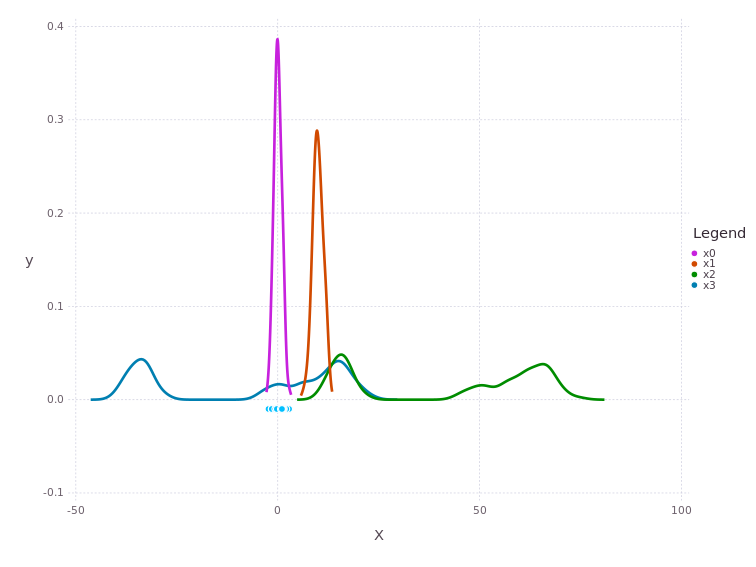

In [8]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
MapVizApp(client)

Notice the `x3` trace is a shifted and slightly spread out version of the belief on `x2`, through the convolution with the conditional belief `P(Z | X2, X3)`.

### The Last Factor

Only by introducing more information into the factor graph can inference extract more precise marginal belief estimates for each of the variables.
A final piece of information added to this graph is a factor directly relating `x3` with `x0`.

In [ ]:
linear_factor = Factor("x3x0f1", "LinearRelative", ["x3", "x0"],
      FactorData(
          fnc=LinearRelative(Normal(30, 1)
          ).dump()  # This is a generator for a LinearRelative
      ))
result_id = await addFactor(navability_client, client, linear_factor)

# let's wait to make sure all nodes were added
await waitForCompletion(navability_client, [result_id])

Pay close attention to what this last factor means in terms of the probability density traces shown in the previous figure.
The trace for `x3` has two major modes, one that overlaps with `x0, x1` near 0 and a second mode further to the left at -40.
The last factor introduces a shift `LinearRelative(Normal(40,1))` which essentially aligns the left most mode of `x3` back onto `x0`.

This last factor forces a mode selection through consensus.
By doing global inference, the new information obtained in `x3` will be equally propagated to `x2` where only one of the two modes will remain.  Let's look at the factor graph again:

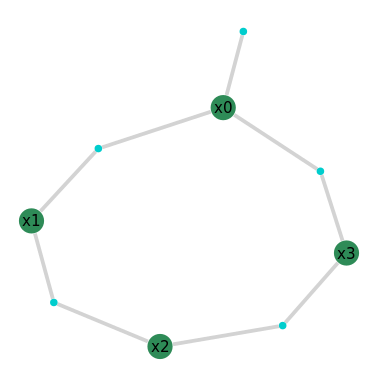

In [9]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
GraphVizApp(client)

## Solve the Graph

Global inference over the full graph can now be triggered.
Again, we use `solveSession` to trigger the final solve in the NavAbility platform.

In [ ]:
solve_request = await solveSession(navability_client, client)
print('running solve...')

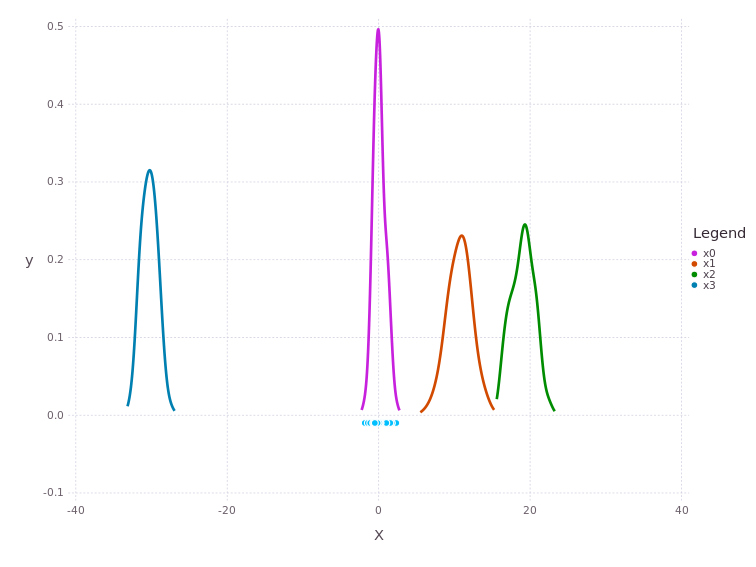

In [10]:
# click the generated graphic to link to the NavAbiltiy WebApp visualization
MapVizApp(client)

The resulting posterior marginal beliefs over all the system variables are:

In [ ]:
variables = await ls(navability_client, client)
print(f"Variables in graph: {variables}")
ppes = {
        v: (await getVariable(navability_client, client, v)).ppes["default"].suggested
        for v in variables
    }
print(ppes)

### The Wheels Did Slip!

Look, the resulting distance from `x1` to `x2` with all the data available turns out to be 10 units -- much less than the 60 units measured by the encoder, coupled with the on and off slip detection.  Our example here is constructed in such a way that when all data is considered together a clear answer can be extracted.  In real situations, the beliefs could be more nuanced -- which is all the more reason to consider non-Gaussian estimation which permanently keeps track of the nuanced features hidden in the data!

## Conclusion

It is important to note that although this tutorial ends with all marginal beliefs having near Gaussian shape and are unimodal, that the package supports multi-modal belief estimates during both the prediction and global inference processes.

## Next Steps

The next tutorial looks at weakly observable (a.k.a. missing / insufficient data, or underdetermined) situations where all Gaussian measurements result in highly non-Gaussian and multi-modal posterior estimates.

### Case Study: Marine Surface Navigation

Furthermore, this tutorial has practical value.  For example, NavAbility developed a GPS-denied navigation technique for marine surface vehicles whereby consecutive radar sweeps are correlated for extracting odometry measurements.  These correlations, as it turns out, are non-Gaussian and on many occasions and exhibit multi-modal behavior similar to the tutorial illustrated above.

**Real World Non-Gaussian Odometry Measurement**

The left image below shows two consecutive `360 degree` radar sweeps from a marine surface vehicle.  The right-hand image shows a slice from the dense correlation map on the `SpecialEuclidean(2)` manifold when looking for the best alignment between the two radar sweeps -- notice the non-Gaussian / multi-modal behavior!  This type of non-Gaussian measurement can readily be used in the NavAbility and Caesar.jl solver system.  See the [NavAbility Marine Surface Navigation Case Study page](https://www.navability.io/applications/marine/) for more details.

![Marine Appl Ex](http://www.navability.io/wp-content/uploads/2022/04/MarineRadarAlignFigure-1024x485-1.png)

[Link to the Marine Application Example](https://www.navability.io/applications/marine/)